In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
from scipy import interpolate

plt.rcParams.update({'font.size': 14})

from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi

from utilities import GS,smoothing, restriction, residual,prolongation

In [2]:
# The name of variable ends with c and f are corse and fine mesh
start = time.time()
Nx1 = 81
Ny1 = 81
Nx2 = 41
Ny2 = 41
Nx3 = 21
Ny3 = 21
L = 1  # length
H = 1  # length

phi1 = np.zeros((Nx1, Ny1))
phi2 = np.zeros((Nx2, Ny2))
phi3 = np.zeros((Nx3, Ny3))

dx1 = L / (Nx1 - 1)  # Grid size
dy1 = L / (Ny1 - 1)  # Grid size
x1_list = np.arange(0, 1 + dx1, dx1)
y1_list = np.arange(0, 1 + dy1, dy1)
x1, y1 = np.meshgrid(x1_list, y1_list, indexing='ij')

dx2 = L / (Nx2 - 1)  # Grid size
dy2 = L / (Ny2 - 1)  # Grid size
x2_list = np.arange(0, 1 + dx2, dx2)
y2_list = np.arange(0, 1 + dy2, dy2)
x2, y2 = np.meshgrid(x2_list, y2_list, indexing='ij')

dx3 = L / (Nx3 - 1)  # Grid size
dy3 = L / (Ny3 - 1)  # Grid size
x3_list = np.arange(0, 1 + dx3, dx3)
y3_list = np.arange(0, 1 + dy3, dy3)
x3, y3 = np.meshgrid(x3_list, y3_list, indexing='ij')

tolf = 1e-6


aE1 = 1 / dx1 ** 2
aW1 = 1 / dx1 ** 2
aN1 = 1 / dy1 ** 2
aS1 = 1 / dy1 ** 2
a01 = -(2 / dx1 ** 2 + 2 / dy1 ** 2)

aE2 = 1 / dx2 ** 2
aW2 = 1 / dx2 ** 2
aN2 = 1 / dy2 ** 2
aS2 = 1 / dy2 ** 2
a02 = -(2 / dx2 ** 2 + 2 / dy2 ** 2)

aE3 = 1 / dx3 ** 2
aW3 = 1 / dx3 ** 2
aN3 = 1 / dy3 ** 2
aS3 = 1 / dy3 ** 2
a03 = -(2 / dx3 ** 2 + 2 / dy3 ** 2)

phi1, S1 = prepare_phi_and_S(Nx1, Ny1, phi1, L, H)
R2_1_old, _, _ = residual(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01, convert=False)


In [3]:
for l in tqdm(range(10000)):
    # Smoothing
    R2_1, R_1_new = smoothing(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01)

    # Resitriction on 2nd grid
    phi2, R2_2, R_2_new = restriction(Nx2, Ny2, R_1_new, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list,multi_sweep=10)

    # Resitriction on 3rd grid
    phi3, R2_3, R_3_new = restriction(Nx3, Ny3, R_2_new, aE3, aW3, aE3, aS3, a03, x2_list, y2_list, x3_list, y3_list,multi_sweep=20)

    phi2 = prolongation(x3_list, y3_list, phi3, x2_list, y2_list, phi2)

    phi1 = prolongation(x2_list, y2_list, phi2, x1_list, y1_list, phi1)

    if l % 20 == 0:
        clear_output(True)
        print('Residual on Fine mesh:', R2_1, 'Residual on Coarse mesh:', R2_2)

    if R2_1 < tolf:
        print('Converged! Residual: ', R2_1, 'Time elapsed: ', time.time() - start)
        break

  0%|          | 23/10000 [00:01<07:30, 22.15it/s]

Residual on Fine mesh: 0.03495348831765762 Residual on Coarse mesh: 0.016077186157929472


  0%|          | 39/10000 [00:01<08:05, 20.53it/s]

Converged! Residual:  8.234494188220936e-07 Time elapsed:  2.0188770294189453


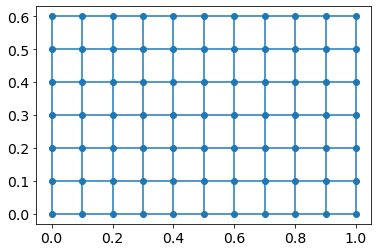

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

x, y = np.meshgrid(np.linspace(0,1, 11), np.linspace(0, 0.6, 7))

plt.scatter(x, y)

segs1 = np.stack((x,y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1))
plt.gca().add_collection(LineCollection(segs2))
plt.show()

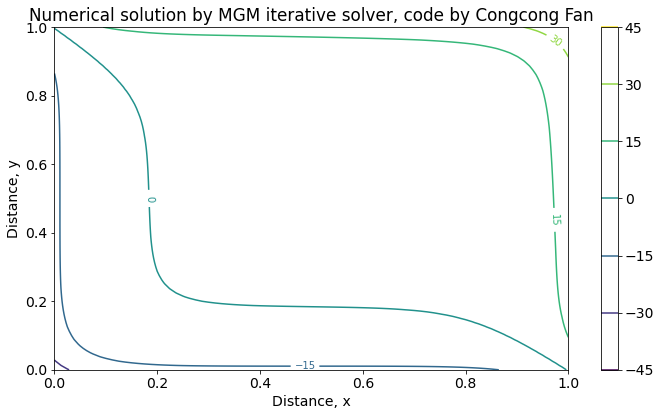

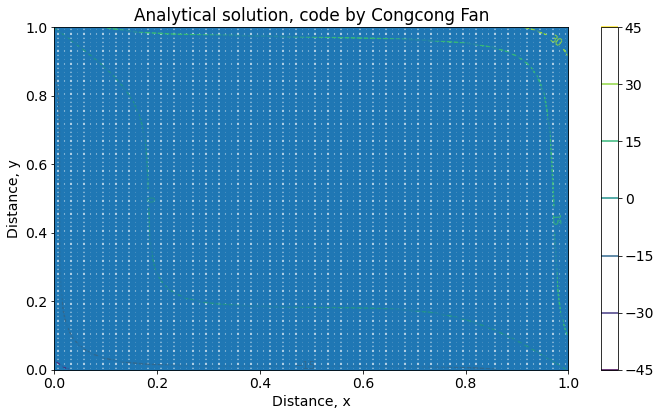

In [5]:

# Analytical solution
x = np.linspace(0,1,Nx1)
y = np.linspace(0,1,Ny1)
phi_A = np.zeros((Nx1,Ny1))
for i in range(Nx1):
    for j in range(Ny1):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi1, phi_A, Nx1, Ny1, 'MGM', convert=False)

from matplotlib.collections import LineCollection
x, y = np.meshgrid(np.linspace(0,1, Nx1), np.linspace(0, 1, Ny1))

plt.scatter(x, y)

segs1 = np.stack((x,y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1))
plt.gca().add_collection(LineCollection(segs2))
plt.show()
